In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

# Загружаем выборку Diamonds

1. PRICE: price in US dollars (326-18,823)
2. CARAT: weight of the diamond (0.2--5.01)
3. CUT: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
4. COLOR: diamond colour, from J (worst) to D (best)
5. CLARITY: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
6. X: length in mm (0--10.74)
7. Y: width in mm (0--58.9)
8. Z: depth in mm (0--31.8)
9. DEPTH: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
10. TABLE: width of top of diamond relative to widest point (43--95)

In [2]:
diamonds_df = pd.read_csv('diamonds.csv')

In [3]:
diamonds_df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


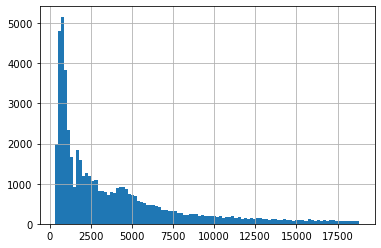

In [4]:
plt.hist(diamonds_df['price'], bins=100)
plt.grid();

# Подготовка данных

In [5]:
features = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']
target = ['price']

In [6]:
cut_transform = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
clarity_transform = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
color_transorm = {'D': 0, 'E': 1, 'F': 2, 'G': 3, 'H': 4, 'I': 5, 'J': 6}

In [7]:
diamonds_df['cut'] = diamonds_df['cut'].apply(lambda x: cut_transform.get(x))
diamonds_df['color'] = diamonds_df['color'].apply(lambda x: color_transorm.get(x))
diamonds_df['clarity'] = diamonds_df['clarity'].apply(lambda x: clarity_transform.get(x))

In [8]:
diamonds_df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,4,1,1,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,3,1,2,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,3,5,3,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,1,6,1,63.3,58.0,335,4.34,4.35,2.75


In [9]:
X = diamonds_df[features].copy().values
y = diamonds_df[target].values

In [10]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=47, test_size=0.3)

# Обучаем модель линейной регрессии

In [12]:
reg = LinearRegression().fit(X_train, y_train)

In [13]:
y_pred = reg.predict(X_test)

In [14]:
score = r2_score(y_pred, y_test)

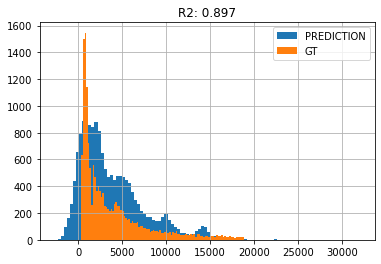

In [15]:
plt.title(f'R2: {str(score)[:5]}')
plt.hist(y_pred, bins=100, label='PREDICTION')
plt.hist(y_test, bins=100, label='GT')
plt.legend()
plt.grid()

# Создаём модель MLP для задачи регрессии

In [16]:
class MLPRegressor:
    def __init__(
            self,
            hidden_layer_sizes=(100,),
            learning_rate=0.001,
            max_iter=10,
            batch_size=32,
            each_iter_log_info = 1000,
        ):
            self.hidden_layer_sizes = hidden_layer_sizes
            self.learning_rate = learning_rate
            self.max_iter = max_iter
            self.batch_size = batch_size
            self.each_iter_log_info = each_iter_log_info
            self.loss_array = []

    def activate(self, t):
        # return 1 / (1 + np.exp(-t))
        return np.maximum(t, 0)

    def loss(self, y_pred, y):
        return (y - y_pred) ** 2

    def initialize_weights(self, input_size, output_size):
        # return np.random.randn(input_size, output_size)
        std_dev = np.sqrt(2 / (input_size + output_size))
        return np.random.randn(input_size, output_size) * std_dev

    def train(self, X, y):
        self.loss_array = []
        iters = X.shape[0]
        input_size = X.shape[1]
        output_size = y.shape[1]

        hidden_layer_sizes = [input_size] + list(self.hidden_layer_sizes) + [output_size]
        weights = []
        biases = []

        for i in range(len(hidden_layer_sizes) - 1):
            w = self.initialize_weights(hidden_layer_sizes[i], hidden_layer_sizes[i + 1])
            b = np.random.randn(1, hidden_layer_sizes[i + 1])
            weights.append(w)
            biases.append(b)

        num_batches = iters // self.batch_size

        for i in range(self.max_iter):
            random_indices = np.arange(iters)
            np.random.shuffle(random_indices)

            for batch_idx in range(num_batches):
                start = batch_idx * self.batch_size
                end = start + self.batch_size
                batch_indices = random_indices[start:end]

                batch_X = X[batch_indices]
                batch_y = y[batch_indices]

                activations = [batch_X]
                for j in range(len(self.hidden_layer_sizes) + 1):
                    t = activations[j] @ weights[j] + biases[j]
                    h = self.activate(t)
                    activations.append(h)

                y_pred = activations[-1]
                error = self.loss(y_pred, batch_y)
                self.loss_array.append(error.mean())

                gradients = [-2 * (batch_y - y_pred) / self.batch_size]
                for j in range(len(self.hidden_layer_sizes), -1, -1):
                    grad_t = gradients[-1]
                    grad_w = activations[j].T @ grad_t
                    grad_b = np.sum(grad_t, axis=0, keepdims=True)
                    grad_h = grad_t @ weights[j].T
                    grad_t = grad_h * (activations[j] > 0)
                    gradients.append(grad_t)

                    weights[j] -= self.learning_rate * grad_w
                    biases[j] -= self.learning_rate * grad_b

            # Проверяем условие завершения обучения
            if i % self.each_iter_log_info == 0:
                print(f"Iteration: {i}, Loss: {np.mean(self.loss_array[-num_batches:])}")

        self.weights = weights
        self.biases = biases


    def predict(self, X):
        activations = [X]
        for j in range(len(self.hidden_layer_sizes) + 1):
            t = activations[j] @ self.weights[j] + self.biases[j]
            h = self.activate(t)
            activations.append(h)
        
        y_pred = activations[-1]
        return y_pred

# Проверяем модель MLP на выборке Diamonds

In [94]:
# mlp_reg_v2 = MLPRegressor(hidden_layer_sizes=(40, 30, 12, 10, 8), learning_rate=0.0000001, max_iter=200, batch_size=80) # 0.9784768740110887
# mlp_reg_v2 = MLPRegressor(hidden_layer_sizes=(41, 28, 14, 8), learning_rate=0.0000001, max_iter=2000, batch_size=80, each_iter_log_info=10) # 0.9808634122178905
mlp_reg_v2 = MLPRegressor(hidden_layer_sizes=(41, 28, 14, 8), learning_rate=0.0000001, max_iter=2000, batch_size=80, each_iter_log_info=10) # 0.9808634122178905

mlp_reg_v2.train(X_train, y_train)
y_mlp_pred2 = mlp_reg_v2.predict(X_test)
mlp_score2 = r2_score(y_mlp_pred2, y_test)
print(mlp_score2)


Iteration: 0, Loss: 22035993.888735477
Iteration: 10, Loss: 695605.2134574678
Iteration: 20, Loss: 574399.2523280008
Iteration: 30, Loss: 481797.9157960691
Iteration: 40, Loss: 464871.4326475752
Iteration: 50, Loss: 443746.1964452288
Iteration: 60, Loss: 417155.096941515
Iteration: 70, Loss: 412534.64726422424
Iteration: 80, Loss: 416042.817889956
Iteration: 90, Loss: 402581.0071232114
Iteration: 100, Loss: 392317.1994983039
Iteration: 110, Loss: 394753.6847313898
Iteration: 120, Loss: 384906.1005915229
Iteration: 130, Loss: 375660.85484526574
Iteration: 140, Loss: 371554.8701413137
Iteration: 150, Loss: 363792.41363304184
Iteration: 160, Loss: 373146.75108525174
Iteration: 170, Loss: 357361.454615284
Iteration: 180, Loss: 365668.50899843307
Iteration: 190, Loss: 355519.86133003613
Iteration: 200, Loss: 357021.32738661615
Iteration: 210, Loss: 351308.44864494115
Iteration: 220, Loss: 348214.4381346252
Iteration: 230, Loss: 345371.97818290646
Iteration: 240, Loss: 342521.1616072636
Iter

In [17]:
# mlp_reg = MLPRegressor(hidden_layer_sizes=(30, ), learning_rate=0.0001, max_iter=4000, batch_size=800) # 0.9578412639919472
# mlp_reg = MLPRegressor(hidden_layer_sizes=(64, ), learning_rate=0.0001, max_iter=4000, batch_size=800) # 0.9740280866221892
# mlp_reg = MLPRegressor(hidden_layer_sizes=(256, ), learning_rate=0.0001, max_iter=4000, batch_size=800) # 0.9752984590039286
# mlp_reg = MLPRegressor(hidden_layer_sizes=(64, ), learning_rate=0.0001, max_iter=10000, batch_size=800) # 0.9680432471044638
# mlp_reg = MLPRegressor(hidden_layer_sizes=(40, 30, 12, 10, 8), learning_rate=0.0000001, max_iter=200, batch_size=80) # 0.9784768740110887
# mlp_reg = MLPRegressor(hidden_layer_sizes=(41, 28, 14, 8), learning_rate=0.0000001, max_iter=2000, batch_size=80, each_iter_log_info=10) # 0.9808634122178905
mlp_reg = MLPRegressor(hidden_layer_sizes=(41, 28, 14, 8), learning_rate=0.0000001, max_iter=5000, batch_size=80, each_iter_log_info=50) # 0.9801260703420671

mlp_reg.train(X_train, y_train)

Iteration: 0, Loss: 31486049.9132235
Iteration: 50, Loss: 435645.38376259845
Iteration: 100, Loss: 387356.0581606278
Iteration: 150, Loss: 367025.86715380277
Iteration: 200, Loss: 357344.18364302296
Iteration: 250, Loss: 346521.24301022175
Iteration: 300, Loss: 336105.41080240184
Iteration: 350, Loss: 330354.03516205
Iteration: 400, Loss: 326381.31474878074
Iteration: 450, Loss: 324295.5669634211
Iteration: 500, Loss: 319925.80359668855
Iteration: 550, Loss: 316466.85898227256
Iteration: 600, Loss: 311976.0940409289
Iteration: 650, Loss: 312578.77477024304
Iteration: 700, Loss: 311591.2394091018
Iteration: 750, Loss: 309489.73406738363
Iteration: 800, Loss: 308130.9061170709
Iteration: 850, Loss: 309800.79609875387
Iteration: 900, Loss: 305599.71553661197
Iteration: 950, Loss: 304258.67168408574
Iteration: 1000, Loss: 304175.76976286824
Iteration: 1050, Loss: 301362.0316281338
Iteration: 1100, Loss: 304392.2639185757
Iteration: 1150, Loss: 302356.6756556291
Iteration: 1200, Loss: 30031

In [23]:
y_mlp_pred = mlp_reg.predict(X_train)
mlp_score = r2_score(y_mlp_pred, y_train)
print(mlp_score)

0.9824808663072752


In [24]:
y_mlp_pred = mlp_reg.predict(X_test)
mlp_score = r2_score(y_mlp_pred, y_test)
print(mlp_score)

0.9801260703420671


In [25]:
print(np.unique(y_mlp_pred))
print(y_train[1])

[  311.67529655   317.15757846   337.09770926 ... 17930.16902509
 18015.07843578 18706.20494767]
[17360]


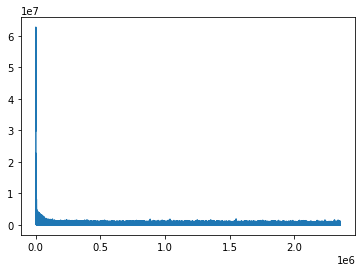

In [26]:
plt.plot(np.array(mlp_reg.loss_array).reshape(1, -1)[0])
plt.show()

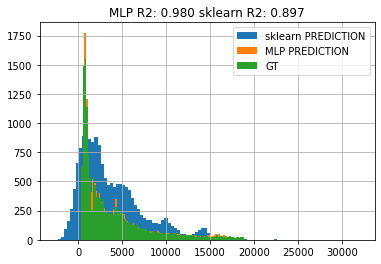

In [27]:
plt.title(f'MLP R2: {str(mlp_score)[:5]} sklearn R2: {str(score)[:5]}')
plt.hist(y_pred, bins=100, label='sklearn PREDICTION')
plt.hist(y_mlp_pred, bins=100, label='MLP PREDICTION')
plt.hist(y_test, bins=100, label='GT')
plt.legend()
plt.grid()